In [1]:
import numpy as np

import os

from statsmodels.stats.api import DescrStatsW
from scipy.stats import ttest_rel, sem

import matplotlib.pyplot as plt
import seaborn as sns
import tikzplotlib

In [2]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    
    return onehot.cumsum(axis=time_axis)


def log_utility(counts):
    return np.log(counts[:, 1:] + 1).sum(axis=1)


def linear_utility(counts):
    return counts[:, 1:].sum(axis=1)


data = 'morgan'

# group_size = 1
# num_exps = 120
# num_repeats_per_exp = 5

group_size = 14
num_exps = 20
num_repeats_per_exp = 1

policies = [
    'ens jensen greedy_500',
    'classical ens_500',
    'greedy',
    'round robin greedy',
    'round robin ens_500',
    # 'round robin ucb_3.0',
    # 'malkomes_0.25',
    # 'malkomes_0.5',
    # 'malkomes_0.75',
    # 'he_cabornell'
]
names = [
    'D-ENS',
    'ENS',
    'One-step',
    'RR-greedy',
    'RR-ENS',
    # 'RR-UCB',
    # '0.25',
    # '0.5',
    # '0.75',
    # 'HC'
]

# policies = [
#     'round robin ucb_0.1',
#     'round robin ucb_0.3',
#     'round robin ucb_1.0',
#     'round robin ucb_3.0',
#     'round robin ucb_10.0',
# ]
# names = policies

assert len(policies) == len(names)
if group_size == 1 and 'round robin greedy' in policies:
    policies.remove('round robin greedy')
    
utility_function = linear_utility

n_classes = group_size + 1
init_size = 1
budget = 500

basepath = os.path.join('../../data/results', data)
# basepath = os.path.join('../../data/results/results_ucb_main', data)
# basepath = os.path.join('../../data/results/results_malkomes', data)
# basepath = os.path.join('../../data/results/results_he_carbonell', data)


utilities = np.ones(
    (len(policies), num_exps, num_repeats_per_exp, budget + init_size)
) * -1
class_counts = -1 * np.ones(
    (len(policies), num_exps, init_size + budget, n_classes), dtype=int
)

for p_ind, policy in enumerate(policies):
    for exp_ind in range(num_exps):
        path = os.path.join(basepath, f'{data}{exp_ind + 1}', str(group_size), policy)
        for i in range(num_repeats_per_exp):
            try:
                labels = np.loadtxt(
                    os.path.join(path, f'{policy}__labels__{i + 1}.csv'), 
                    dtype=int
                ).flatten() - 1

                utilities[p_ind, exp_ind, i, :] = utility_function(labels_to_counts(labels))
                class_counts[p_ind, exp_ind, :, :] = labels_to_counts(labels)
            except OSError:
                print(os.path.join(path, f'{policy}__labels__{i + 1}.csv'))
                print(policy, exp_ind + 1, i + 1)
        
assert np.all(utilities != -1)

In [3]:
class_counts.shape

(5, 20, 501, 15)

In [4]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {(class_counts[p_ind, :, -1, :] > 0).sum(axis=1).mean(axis=0)}')

ens jensen greedy_500: 11.05
classical ens_500: 6.75
greedy: 8.8
round robin greedy: 9.45
round robin ens_500: 8.7


In [8]:
(class_counts[p_ind, :, -1, :] > 0).sum(axis=1)

array([ 9,  6, 10,  9,  9, 11,  6,  7, 11,  7,  9, 11, 10,  7,  8,  9, 10,
       10,  8,  7])

In [9]:
for p1 in range(len(policies) - 1):
    for p2 in range(p1 + 1, len(policies)):
        if (class_counts[p1, :, -1, :] > 0).sum(axis=1).mean(axis=0) < (class_counts[p2, :, -1, :] > 0).sum(axis=1).mean(axis=0):
            alternative = "less"
        else:
            alternative = "greater"
        
        print(policies[p1], "vs.", policies[p2])
        print(
            ttest_rel(
                (class_counts[p1, :, -1, :] > 0).sum(axis=1), 
                (class_counts[p2, :, -1, :] > 0).sum(axis=1),
                # alternative=alternative
            ).pvalue
        )
    print()

ens jensen greedy_500 vs. classical ens_500
6.198980469270381e-08
ens jensen greedy_500 vs. greedy
0.001576396914624515
ens jensen greedy_500 vs. round robin greedy
0.00580937048206876
ens jensen greedy_500 vs. round robin ens_500
0.00015204092726874436

classical ens_500 vs. greedy
0.002905562510867163
classical ens_500 vs. round robin greedy
5.025200468361675e-05
classical ens_500 vs. round robin ens_500
0.0016064091743179713

greedy vs. round robin greedy
0.2848350073532697
greedy vs. round robin ens_500
0.8409418155058108

round robin greedy vs. round robin ens_500
0.0783618257927472



In [5]:
utilities.shape

(5, 20, 1, 501)

In [6]:
utilities[..., -1].mean(axis=(1, 2))

array([258.4 , 427.95, 355.15, 180.8 , 394.45])

ens jensen greedy_500: 258.40
classical ens_500: 427.95
greedy: 355.15
round robin greedy: 180.80
round robin ens_500: 394.45


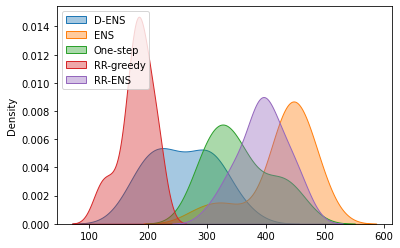

In [7]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {utilities[p_ind, ..., -1].mean():.2f}')
    sns.kdeplot(utilities[p_ind, ..., -1].flatten(), alpha=0.4, shade=True, label=names[p_ind])
    
plt.legend(loc='upper left');

In [8]:
print(utilities.shape)
utilities

(2, 20, 1, 501)


array([[[[ 0.69314718,  0.69314718,  0.69314718, ..., 23.59131932,
          23.66031219, 23.72485071]],

        [[ 0.69314718,  1.09861229,  1.09861229, ..., 21.27276729,
          21.28876763, 21.30451599]],

        [[ 0.69314718,  0.69314718,  1.09861229, ..., 18.82406369,
          18.84604259, 18.8680215 ]],

        ...,

        [[ 0.69314718,  0.69314718,  1.09861229, ..., 21.1276426 ,
          21.1276426 , 21.1276426 ]],

        [[ 0.69314718,  0.69314718,  0.69314718, ..., 20.58764733,
          20.58764733, 20.58764733]],

        [[ 0.69314718,  0.69314718,  0.69314718, ..., 26.40595394,
          26.43874376, 26.43874376]]],


       [[[ 0.69314718,  0.69314718,  1.09861229, ..., 18.41486547,
          18.5326485 , 18.5326485 ]],

        [[ 0.69314718,  1.09861229,  1.38629436, ..., 20.0639183 ,
          20.0639183 , 20.07830704]],

        [[ 0.69314718,  1.09861229,  1.38629436, ..., 15.1543988 ,
          15.1543988 , 15.1689976 ]],

        ...,

        [[ 0.693

In [9]:
squeezed_utilities =  utilities.reshape(
    len(policies), 
    num_exps * num_repeats_per_exp, 
    budget + init_size
)

print(squeezed_utilities.shape)
squeezed_utilities

(2, 20, 501)


array([[[ 0.69314718,  0.69314718,  0.69314718, ..., 23.59131932,
         23.66031219, 23.72485071],
        [ 0.69314718,  1.09861229,  1.09861229, ..., 21.27276729,
         21.28876763, 21.30451599],
        [ 0.69314718,  0.69314718,  1.09861229, ..., 18.82406369,
         18.84604259, 18.8680215 ],
        ...,
        [ 0.69314718,  0.69314718,  1.09861229, ..., 21.1276426 ,
         21.1276426 , 21.1276426 ],
        [ 0.69314718,  0.69314718,  0.69314718, ..., 20.58764733,
         20.58764733, 20.58764733],
        [ 0.69314718,  0.69314718,  0.69314718, ..., 26.40595394,
         26.43874376, 26.43874376]],

       [[ 0.69314718,  0.69314718,  1.09861229, ..., 18.41486547,
         18.5326485 , 18.5326485 ],
        [ 0.69314718,  1.09861229,  1.38629436, ..., 20.0639183 ,
         20.0639183 , 20.07830704],
        [ 0.69314718,  1.09861229,  1.38629436, ..., 15.1543988 ,
         15.1543988 , 15.1689976 ],
        ...,
        [ 0.69314718,  1.09861229,  1.38629436, ..., 1

In [10]:
for p1 in range(len(policies) - 1):
    for p2 in range(p1 + 1, len(policies)):
        if squeezed_utilities[p1, :, -1].mean() < squeezed_utilities[p2, :, -1].mean():
            alternative = "less"
        else:
            alternative = "greater"
        
        print(policies[p1], "vs.", policies[p2])
        print(
            ttest_rel(
                squeezed_utilities[p1, :, -1], 
                squeezed_utilities[p2, :, -1],
                # alternative=alternative
            ).pvalue
        )
    print()

ens jensen greedy_500 vs. greedy
0.0012456630498968765



21.728115956136065 25.057441307148338
0.83
17.11255294361891 21.014933224800806
0.98


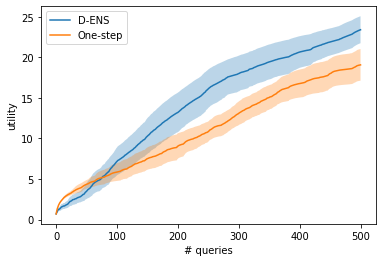

In [11]:
plt.figure()

for p_ind, policy in enumerate(policies):
    plt.plot(squeezed_utilities[p_ind].mean(axis=0), label=names[p_ind])
    lower, upper = DescrStatsW(squeezed_utilities[p_ind]).tconfint_mean()
    plt.fill_between(np.arange(init_size + budget), lower, upper, alpha=0.3)
    
    print(lower[-1], upper[-1])
    print(f'{(upper[-1] - lower[-1]) / 4:.2f}')
    
plt.xlabel("# queries")
plt.ylabel("utility")
plt.legend()

tikzplotlib.save("reward.tex")

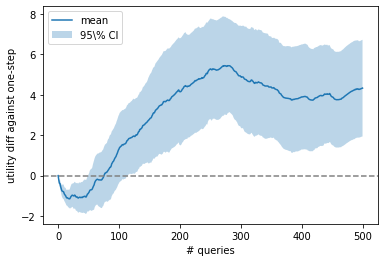

In [12]:
diff = squeezed_utilities[0] - squeezed_utilities[1]
lower, upper = DescrStatsW(diff).tconfint_mean()

plt.plot(diff.mean(axis=0), label="mean")
plt.fill_between(np.arange(init_size + budget), lower, upper, alpha=0.3, label="95\% CI")

plt.axhline(0, c="gray", linestyle="--")

plt.xlabel("# queries")
plt.ylabel("utility diff against one-step")
# plt.ylim(-5, 30)

plt.legend(loc="upper left")

# plt.show()
tikzplotlib.save("reward_diff.tex")